# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="C:/Users/u224870/Projekte/deep-reinforcement-learning/p1_navigation/Banana_Windows_x86_64/Banana_Windows_x86_64/Banana.exe", no_graphics=True);

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity last two entries of the state.
The other 35 dimensions are ray-based perception of objects around agent's forward direction. This includes binary information about what is present and real number value to indicate the distance (I think). 

A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Train a dueling DDQN agent to solve the problem

We start by inporting some more libraries necessary for training.
First we import the Agent (you can find the file in '/agent/DQN_Agent.py').
We use collections and pyplot to monitor the progress during learning.

In [5]:
from agent.DQN_Agent import Agent
from collections import deque
import matplotlib.pyplot as plt
from IPython import display

cpu


### Hyperparameter
We chose the hyperparameters for training. To sample the hyperparameters it would be better to work outside of a notebook. Due to the quick convergence of the algorithm with the initial hyperparameters we don't need to sample for better performing parameters.

Here we introduce a vector limited_actions. This was mainly used early in the developing process to see if the agent could also solve the task when certain options are removed (e.g. remove option to walk backwards, since all sensors are front facing).

Hyperparameters:

- eps - Initial epsilon set to 1 => Full exploration and no exploitation for untrained agent
- eps_min - Minimal exploration will remain during all of training
- epd_decay - This parameter defines how fast the agent will start exploiting the learned strategy

All other hyperparameters are set in the Agent and Model files.

In [6]:
DQN = Agent(state_size=state_size, action_size=action_size,double_dqn=False,dueling=False,  seed=0)
DDQN = Agent(state_size=state_size, action_size=action_size,double_dqn=False,dueling=True,  seed=0)
doubleDQN =Agent(state_size=state_size, action_size=action_size,double_dqn=True,dueling=False,  seed=0)
doubleDDQN = Agent(state_size=state_size, action_size=action_size,double_dqn=True,dueling=True,  seed=0)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
limited_actions = [0,1,2,3]
eps = 1.
eps_min = 0.001
eps_decay = 0.995

Initialize the parameters for plotting and keeping track of the score.

### Training through interaction with the environment
Here we let the agent interact with the environment and gain experiences. The experiences are stored as tuples containing:
- state - Observation of the environment consisting of a 37 dimensional array
- action - Action the agent performed to get from state => next_state
- reward - The environment returns a reward [-1,0,1] after each action 
- next_state - The next state the environment is in after the agent performed an action
- done - Whether the environment has terminated or not (This is important for the Q-Value update)

If the agent achieves an average score above 13, we save the network weights. We also check for best perfoming agent_state and save the network whenever a new record is set.

In [7]:
def TrainAgent(agent):
    n_episodes = 1000
    limited_actions = [0,1,2,3]
    eps = 1.
    eps_min = 0.001
    eps_decay = 0.995
    max_score = 0.
    mean_score = deque(maxlen = 100)
    success = deque(maxlen = 100)
    plot_success =[]
    plot_score = []
    solved = False
    for i in range(1,n_episodes+1):
        score = 0 # initialize the score
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        while True:
            action = agent.act(state, eps)        # select an action
            env_info = env.step(limited_actions[action])[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state,done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        # Get a feeling of how many episode terminate above a score of 13.
        if score >= 13.:
            success.append(1.)
        else:
            success.append(0.)
        # Check if desired performance is reached
        if np.mean(mean_score) >= 13. and not solved:
            solved = True
            solved_after = i
            agent.save('./Nets/sucessful_network.pth')
        if score > max_score and score > 13.:
            max_score = score
            agent.save('./Nets/best_network.pth')
        mean_score.append(score)
        plot_success.append(10*np.mean(success))
        plot_score.append(np.mean(mean_score))
        eps = max(eps_min, eps_decay * eps)  # decrease epsilon   
        if solved:
            print("Done after {} Episodes!".format(solved_after))
        print('\rEpisode {}\tAverage Score: {:.2f} \tAverage Successrate: {:.0f} \tEpsilon: {}'.format(i, np.mean(mean_score),100*np.mean(success),eps), end="")
        #plt.plot(plot_success)
        plt.plot(plot_score)
        plt.xlabel("Episode")
        plt.ylabel("Average Score")
        plt.show()

        display.clear_output(wait=True)
    return mean_score

Done after 523 Episodes!
Episode 1000	Average Score: 15.17 	Average Successrate: 78 	Epsilon: 0.006653968578831948

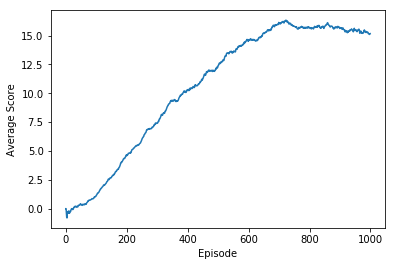

In [8]:
score_DQN = TrainAgent(DQN)

Done after 514 Episodes!
Episode 1000	Average Score: 14.86 	Average Successrate: 73 	Epsilon: 0.006653968578831948

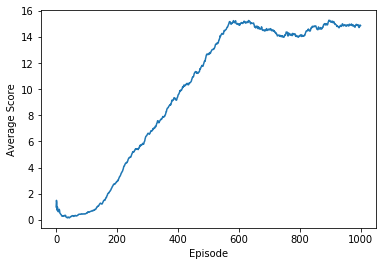

In [9]:
score_doubleDQN = TrainAgent(doubleDQN)

Done after 525 Episodes!
Episode 893	Average Score: 14.79 	Average Successrate: 76 	Epsilon: 0.01137656378004644

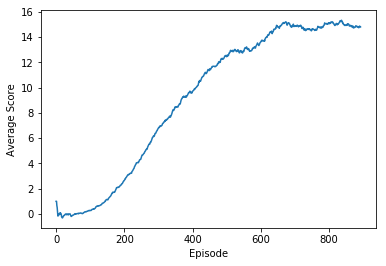

In [ ]:
score_DDQN = TrainAgent(DDQN)

In [ ]:
score_doubleDDQN = TrainAgent(doubleDDQN)

In [ ]:
fig, ax = plt.subplots()
ax.plot(score_DQN, 'k--', label='DQN')
ax.plot(score_doubleDQN, 'k:', label='double DQN')
ax.plot(score_DDQN, 'k', label='DDQN')
ax.plot(score_doubleDDQN, 'k', label='doubleDDQN')
plt.xlabel("Episode")
plt.ylabel("Average Score")
plt.show()

In [ ]:
plt.plot(plot_success)
plt.plot(plot_score)
plt.xlabel("Episode")
plt.ylabel("Average Score")
plt.savefig("./Training.png")

In [ ]:
env.close()